In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
class BoundingBox:
    def __init__(self, origin_x, origin_y, width, height):
        self.origin = np.array([origin_x, origin_y], dtype=np.float)
        self.size = np.array([width, height], dtype=np.float)
        
    @classmethod
    def fromNumPy(cls, origin, size):
        return cls(origin[0], origin[1], size[0], size[1])

    def __repr__(self):
        'Return a nicely formatted representation string'
        return 'BoundingBox(origin=%s, size=%s, center=%s)' % (self.origin, self.size, self.center())
    
    def center(self):
        return self.origin + self.size / 2

In [3]:
class BoundingBoxTransform:
    def __init__(self, translation_x, translation_y, scale_x, scale_y):
        self.translation = np.array([translation_x, translation_y], dtype=np.float)
        self.scale = np.array([scale_x, scale_y], dtype=np.float)
    
    @classmethod
    def fromNumPy(cls, translation, scale):
        'Return aTb'
        return cls(translation[0], translation[1], scale[0], scale[1])
        
    @classmethod
    def fromTwoBoundingBoxes(cls, bbxA, bbxB):
        'Return aTb'
        return cls.fromNumPy((bbxB.origin - bbxA.origin)/bbxA.size, bbxB.size/bbxA.size)

    def __repr__(self):
        'Return a nicely formatted representation string'
        return 'BoundingBox(translation=%s, scale=%s)' % (self.translation, self.scale)
    
    def matrix(self):
        'Returns the transformation matrix'
        tfm = np.identity(3, dtype=np.float)
        tfm[:2, 2] = self.translation
#         tfm.diagonal()[:2] = self.scale
        tfm[0,0] = self.scale[0]
        tfm[1,1] = self.scale[1]
        return tfm
        

In [4]:
bbxA = BoundingBox(0, 0, 640, 480)
bbxB = BoundingBox(0, 0, 640, 240)
print 'bbxA=', bbxA
print 'bbxA=', bbxB

aTb = BoundingBoxTransform.fromTwoBoundingBoxes(bbxA, bbxB)
print 'aTb=', aTb

bbxA= BoundingBox(origin=[ 0.  0.], size=[ 640.  480.], center=[ 320.  240.])
bbxA= BoundingBox(origin=[ 0.  0.], size=[ 640.  240.], center=[ 320.  120.])
aTb= BoundingBox(translation=[ 0.  0.], scale=[ 1.   0.5])


In [5]:
def getTightBBox(image):
    alpha = image[:,:,3].astype(bool)
    nonzero_idxs = np.nonzero(alpha)
    left = nonzero_idxs[1].min()
    right = nonzero_idxs[1].max() + 1
    top = nonzero_idxs[0].min()
    bottom = nonzero_idxs[0].max() + 1
    w = right - left
    h = bottom - top
    return BoundingBox(left, top, w, h)

In [6]:
def getRectanglePatch(bbx, linewidth=1, edgecolor='r'):
    origin = np.floor(bbx.origin).astype(np.int)
    return plt.Rectangle(origin, bbx.size[0], bbx.size[1], fill=False, linewidth = linewidth, edgecolor = edgecolor)

In [7]:
def cropImage(image, bbx):
    left_top = np.floor(bbx.origin).astype(np.int)
    right_bottom = np.floor(bbx.origin + bbx.size).astype(np.int)
    return image[left_top[1]:right_bottom[1], left_top[0]:right_bottom[0]]

In [8]:
def getRGBImage(image_):
    if image_.ndim == 3:
        if image_.shape[2] == 3:
            image = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        elif image_.shape[2] == 4:
            image = cv2.cvtColor(image_, cv2.COLOR_BGRA2RGBA)
        else:
            image = image_
    else:
        image = image_
    return image

In [9]:
image_bbx = BoundingBox(0, 0, 960.0, 540.0)

In [10]:
d_img = cv2.imread('../build/model_d2.png',cv2.IMREAD_UNCHANGED)
amodal_bbx = getTightBBox(d_img)
print 'amodal_bbx=', amodal_bbx

amodal_bbx= BoundingBox(origin=[ 268.  194.], size=[ 437.  190.], center=[ 486.5  289. ])


In [11]:
crop_bbx = BoundingBox.fromNumPy(amodal_bbx.origin + np.array([50, 10]), amodal_bbx.size + np.array([-30, 15]))
print 'crop_bbx = ', crop_bbx
crop_img = cropImage(d_img, crop_bbx)
crop_img.shape


crop_bbx =  BoundingBox(origin=[ 318.  204.], size=[ 407.  205.], center=[ 521.5  306.5])


(205, 407, 4)

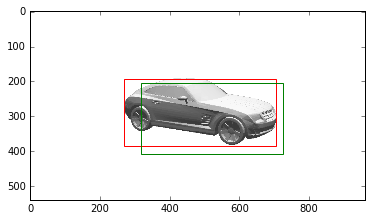

In [12]:
fig,ax = plt.subplots(1)
ax.imshow(getRGBImage(d_img))
ax.add_patch(getRectanglePatch(amodal_bbx, edgecolor='r'))
ax.add_patch(getRectanglePatch(crop_bbx, edgecolor='g'))
plt.show()

In [13]:
aTc = BoundingBoxTransform.fromTwoBoundingBoxes(amodal_bbx, crop_bbx)
iTc = BoundingBoxTransform.fromTwoBoundingBoxes(image_bbx, crop_bbx)
iTa = BoundingBoxTransform.fromTwoBoundingBoxes(image_bbx, amodal_bbx)
print 'aTc=', aTc
print 'iTc=', iTc
print 'iTa=', iTa

aTc= BoundingBox(translation=[ 0.11441648  0.05263158], scale=[ 0.93135011  1.07894737])
iTc= BoundingBox(translation=[ 0.33125     0.37777778], scale=[ 0.42395833  0.37962963])
iTa= BoundingBox(translation=[ 0.27916667  0.35925926], scale=[ 0.45520833  0.35185185])


In [14]:
iTc.matrix()

array([[ 0.42395833,  0.        ,  0.33125   ],
       [ 0.        ,  0.37962963,  0.37777778],
       [ 0.        ,  0.        ,  1.        ]])

In [15]:
iTa.matrix().dot(aTc.matrix())

array([[ 0.42395833,  0.        ,  0.33125   ],
       [ 0.        ,  0.37962963,  0.37777778],
       [ 0.        ,  0.        ,  1.        ]])

In [16]:
assert (iTc.matrix() == iTa.matrix().dot(aTc.matrix())).all()

In [17]:
cv2.imwrite('../build/crop_img.png', crop_img)
cv2.imwrite('../build/crop_img_224x224.png', cv2.resize(crop_img, (224, 224)))

True